# FishTech DS Skills Challenge

netflowlow you will find a link to another publicly available dataset, Unifed Host and Network Data Set, from the Advanced Research in Cyber Systems containing additional links for the download of the two data sources:  network and host events.  The goal is to complete as much as possible and add as much of your personality as you can.  Please use Day 90 from both datasets for your model.  If the two datasets are still too large, please select a random subset for your analysis [i.e. 1 million events, 10 million events, etc.]

 

https://csr.lanl.gov/data/2017/

 

Please send finished results over to me via email by Monday, December 6th, at 10:00 AM central.

 

The team will review your results, and you can expect a response from me by the end of next week.

 

Summary

Using Python, create a simple data model and algorithm for identifying anomalous or risky activity.

 

Minimum Requirements

   - Code for ETL, joins, and random sample [if necessary] of the two data sources
   - Standard data model
   - Algorithm utilizing machine learning function(s) for identifying anomalous or risky activity
   - Visualizations and descriptions of the steps taken to identify relevant activity
   - Concise summary for using the various Python packages, overall methodology, and results

 

Bonus Points but Not Required

   - Risk score and methodology for all hosts
   - Concise presentation slides for all completed work

 

When You are Finished

Please send me the links to the Git repo(s) containing your work.  Again, reach out to me if you have any questions between now and your submission.

 

# Agenda

This is a detailed coding walkthrough of the approach taken to identify anomalous activity from the net flow and host event data for day=90 as described the in challenge description in the previous section. Over the course of this document, I will demonstrate a scalable and effective method of detecting outlier behavior with respect to other similar machines or clusters. 

This document consists of four main parts:
- [Data Ingestion And parsing](#DataParsing)
- [Exploratory Analysis and Observations](#EDA)
- [Data Model And Feature Extraction](#DataModel)
- [Unsupervised Outlier Detection Methodology](#ML)

Along with this document, a very high level "Executive Summary" was produced that excludes most of the fun details. 

<a id='DataParsing'></a>
# Data Ingestion And parsing

This data is pretty big. I'm working in a Jupyter All Spark  docker environment on my personal machine which will allow for me to hopefully parallelize as many actions as possible. https://jupyter-docker-stacks.readthedocs.io/en/latest/index.htmlhttps://jupyter-docker-stacks.readthedocs.io/en/latest/index.html

I'm going start by ingesting and translating the files those to spark dataframes and then saving to partitioned parquet files. These will be faster to read and query from that point on. 


Below is initial imports setting some jupyter setttings that I prefer as well as base packages and setting up the spark context.


In [1]:
from IPython.core.interactiveshell import InteractiveShell

InteractiveShell.ast_node_interactivity = "all"

from pathlib import Path

import numpy as np
import pandas as pd



import jedi

jedi.settings.call_signatures_validity = 5.0
jedi.settings.add_bracket_after_function = True
jedi.settings.case_insensitive_completion = True

In [2]:
import pyspark

# spark = pysspark.sql.SparkSession.builder.master("local[6]").appName("Hello World").getOrCreate()
# The local[6]" parameter specicifies to connect to the local spark instance but with 6 threads for the executor. Many fast!

try:
    sc.stop()
except:
    print("")
try:
    spark.stop()
except:
    print("")

config = pyspark.SparkConf().setAll(
    [
        ("spark.executor.memory", "32g"),
        ("spark.executor.cores", "20"),
        ("spark.cores.max", "20"),
        ("spark.driver.memory", "32g"),
        ("spark.sql.warehouse.dir", r"/home/jovyan/work/sparkData"),
    ]
)

sc = pyspark.SparkContext(conf=config)

spark = pyspark.sql.SparkSession.builder.config(conf=config).getOrCreate()

Using Spark's default log4j profile: org/apache/spark/log4j-defaults.properties
Setting default log level to "WARN".
To adjust logging level use sc.setLogLevel(newLevel). For SparkR, use setLogLevel(newLevel).
21/12/05 17:22:09 WARN NativeCodeLoader: Unable to load native-hadoop library for your platform... using builtin-java classes where applicable


In [24]:
from pyspark.sql.types import IntegerType, LongType, StringType, StructField, StructType

schema = StructType(
    [
        StructField("Time", IntegerType(), True),
        StructField("Duration", IntegerType(), True),
        StructField("SrcDevice", StringType(), True),
        StructField("DstDevice", StringType(), True),
        StructField("Protocol", StringType(), True),
        StructField("SrcPort", StringType(), True),
        StructField("DstPort", StringType(), True),
        StructField("SrcPackets", LongType(), True),
        StructField("DstPackets", LongType(), True),
        StructField("SrcBytes", LongType(), True),
        StructField("DstBytes", LongType(), True),
    ]
)
netflow = spark.read.csv(path="Data/netflow_day-90", schema=schema, header=False)

In [25]:
netflow.show(3)

+-------+--------+----------+----------+--------+---------+-------+----------+----------+--------+--------+
|   Time|Duration| SrcDevice| DstDevice|Protocol|  SrcPort|DstPort|SrcPackets|DstPackets|SrcBytes|DstBytes|
+-------+--------+----------+----------+--------+---------+-------+----------+----------+--------+--------+
|7689600|       0|Comp580697|Comp275646|      17|Port08290|     53|         1|         0|      75|       0|
|7689600|       0|Comp580697|Comp275646|      17|Port81132|     53|         1|         0|      75|       0|
|7689600|       0|Comp580697|Comp275646|      17|Port21353|     53|         1|         0|      75|       0|
+-------+--------+----------+----------+--------+---------+-------+----------+----------+--------+--------+
only showing top 3 rows



In [33]:
netflow = netflow.repartition(30)

This essentially breaks the single large file into lots of smaller chunks that can then be saved to parquet which will retain those partitions as well as store the data in columnar format which is generally better for feature engineering and aggregate type queries. Spark suggests aiming for 100-1000 mb per partion. 

In [36]:
%%time
netflow.write.parquet("TransformedData/netflow.parquet", mode="overwrite")

CPU times: user 67.6 ms, sys: 16.5 ms, total: 84 ms
Wall time: 1min 51s


Since we have this figured out we can roll it all into one line of code for hostEvents. Also, since hostEvents is Json, Spark can infer the schema.

Another interesting piece of information. After parsing these to parquet, they are significantly smaller size on disk. From about 8Gb each file to: hostEvent = 623MB. Netflow = 2.08 GB. 

In [37]:
hostEvents = (
    spark.read.json(path="Data/wls_day-90")
    .repartition(30)
    .write.parquet("TransformedData/hostEvent.parquet", mode="overwrite")
)

In [4]:
netflow = spark.read.parquet("TransformedData/netflow.parquet")
netflow.printSchema()

root
 |-- Time: integer (nullable = true)
 |-- Duration: integer (nullable = true)
 |-- SrcDevice: string (nullable = true)
 |-- DstDevice: string (nullable = true)
 |-- Protocol: string (nullable = true)
 |-- SrcPort: string (nullable = true)
 |-- DstPort: string (nullable = true)
 |-- SrcPackets: long (nullable = true)
 |-- DstPackets: long (nullable = true)
 |-- SrcBytes: long (nullable = true)
 |-- DstBytes: long (nullable = true)



In [5]:
netflow.count()

135710585

In [6]:
netflow.show(10)

+-------+--------+-------------------+-------------------+--------+---------+---------+----------+----------+--------+--------+
|   Time|Duration|          SrcDevice|          DstDevice|Protocol|  SrcPort|  DstPort|SrcPackets|DstPackets|SrcBytes|DstBytes|
+-------+--------+-------------------+-------------------+--------+---------+---------+----------+----------+--------+--------+
|7690539|     287|         Comp257274|         Comp804839|       6|Port82376|Port85926|         1|         1|      60|      46|
|7689842|       0|         Comp012725|         Comp275646|      17|Port84219|       53|         1|         0|     118|       0|
|7690290|       1|         Comp003990|         Comp852539|       6|Port08828|      443|         0|        17|       0|   18302|
|7690300|     496|         Comp107130|         Comp309567|       6|Port56978|      443|        10|         6|    1581|     834|
|7690905|     301|         Comp965575|         Comp356260|       6|Port06668|Port14274|         4|      

Quick check to make sure the long data types were big enough for the number of bytes transferred. 

In [7]:
netflow.createOrReplaceGlobalTempView("netflow")

In [8]:
sqlQuery = """select max(SrcBytes), max(DstPackets) from global_temp.netflow"""
spark.sql(sqlQuery).show()

+-------------+---------------+
|max(SrcBytes)|max(DstPackets)|
+-------------+---------------+
|  31569888509|       77760703|
+-------------+---------------+



In [9]:
hostEvents = spark.read.parquet("TransformedData/hostEvent.parquet")
hostEvents.printSchema()

root
 |-- AuthenticationPackage: string (nullable = true)
 |-- Destination: string (nullable = true)
 |-- DomainName: string (nullable = true)
 |-- EventID: long (nullable = true)
 |-- FailureReason: string (nullable = true)
 |-- LogHost: string (nullable = true)
 |-- LogonID: string (nullable = true)
 |-- LogonType: long (nullable = true)
 |-- LogonTypeDescription: string (nullable = true)
 |-- ParentProcessID: string (nullable = true)
 |-- ParentProcessName: string (nullable = true)
 |-- ProcessID: string (nullable = true)
 |-- ProcessName: string (nullable = true)
 |-- ServiceName: string (nullable = true)
 |-- Source: string (nullable = true)
 |-- Status: string (nullable = true)
 |-- SubjectDomainName: string (nullable = true)
 |-- SubjectLogonID: string (nullable = true)
 |-- SubjectUserName: string (nullable = true)
 |-- Time: long (nullable = true)
 |-- UserName: string (nullable = true)



In [10]:
hostEvents.createOrReplaceGlobalTempView("hostEvents")

In [11]:
hostEvents.count()

39876807

In [13]:
hostEvents.limit(2).toPandas().T

,0,1
AuthenticationPackage,None,NTLM
Destination,None,None
DomainName,Domain001,Domain001
EventID,4688,4624
FailureReason,None,None
LogHost,Comp939065,Comp894088
LogonID,0x3e7,0x7b79fa7f
LogonType,NaN,3.0
LogonTypeDescription,None,Network
ParentProcessID,0x2d08,None


<a id='EDA'></a>
# Exploratory Analysis and Observations
Will do some rudimentary EDA to familiarize ourselves with the data sets which can help guide next steps. 

What event types occurr the most and with what status, if any? 

In [14]:
sqlQuery = """
select
	h.eventID,
	h.Status,
	count(*) ncount
from
	global_temp.hostEvents h
group by
	h.EventID,
	h.status
order by
	ncount desc"""
spark.sql(sqlQuery).show(100)

+-------+----------+--------+
|eventID|    Status|  ncount|
+-------+----------+--------+
|   4688|      null|12257481|
|   4624|      null|10105389|
|   4634|      null| 9842739|
|   4672|      null| 2997921|
|   4776|       0x0| 1919146|
|   4769|       0x0| 1250783|
|   4648|      null|  650141|
|   4768|       0x0|  449943|
|   4776|0xc0000234|  154199|
|   4625|      null|  135130|
|   4776|0xc000006a|   63240|
|   4776|0xc0000064|   44697|
|   4774|      null|    1605|
|   4803|      null|     952|
|   4802|      null|     948|
|   4800|      null|     751|
|   4801|      null|     694|
|   4647|      null|     362|
|   4776|0xc0000199|     306|
|   4776|0xc0000072|     132|
|   4608|      null|      84|
|   4770|      null|      83|
|   1100|      null|      76|
|   4609|      null|       5|
+-------+----------+--------+



Are there any hosts with large number of users associated with them? Do those make sense? 

In [15]:
sqlQuery = """
select
	h.loghost,
	count(1) as ncount,
	count(distinct h.username) as userCount
from
	global_temp.hostEvents h
group by
	h.loghost
order by
	userCount desc"""
spark.sql(sqlQuery).show(10)

+-------------------+--------+---------+
|            loghost|  ncount|userCount|
+-------------------+--------+---------+
|    ActiveDirectory|14942261|    13945|
|         Comp370444|  225464|     4347|
|         Comp915658|   22029|     1864|
|         Comp546675|    9318|     1090|
|         Comp056180|    1991|      518|
|         Comp916004| 3961012|      368|
|         Comp081330|  141893|      297|
|         Comp457448|   14436|      234|
|EnterpriseAppServer| 2830324|      230|
|         Comp939275|   52160|      218|
+-------------------+--------+---------+
only showing top 10 rows



Just a quick look at how many hosts, domains and users there are in this dataset. 

In [16]:
sqlQuery = """select
	count(distinct h.loghost) as hostCount,
	count(distinct domainName) as domainCount,
	count(distinct userName ) as userCount
from
	global_temp.hostEvents h
"""

spark.sql(sqlQuery).show(10)

+---------+-----------+---------+
|hostCount|domainCount|userCount|
+---------+-----------+---------+
|     7774|        142|    14398|
+---------+-----------+---------+



The EventID = 4625 is associated with a failed logon. I just want to see what some of this data looks like. This leads me to be curious about the categories for FailureReason and their counts.

In [17]:
sqlQuery = """select * from global_temp.hostevents h where h.eventID = 4625"""
spark.sql(sqlQuery).limit(3).toPandas()

,AuthenticationPackage,Destination,DomainName,EventID,FailureReason,LogHost,LogonID,LogonType,LogonTypeDescription,ParentProcessID,...,ProcessID,ProcessName,ServiceName,Source,Status,SubjectDomainName,SubjectLogonID,SubjectUserName,Time,UserName
0,Kerberos,None,Domain001,4625,An Error occured during Logon.,Comp207493,0x3e7,3,Network,None,...,0xec0,Proc275807.exe,None,Comp207493,None,None,None,None,7690171,Comp207493$
1,NTLM,None,Domain001,4625,Unknown user name or bad password.,Comp916004,None,3,Network,None,...,None,None,None,Comp304741,None,None,None,None,7690067,User856104
2,Kerberos,None,Domain001,4625,An Error occured during Logon.,Comp207493,0x3e7,3,Network,None,...,0xec0,Proc275807.exe,None,Comp207493,None,None,None,None,7689865,Comp207493$


In [18]:
sqlQuery = """
select
	failurereason,
	count(*) as eventCount,
	count(distinct domainName) as domainCount,
	count(distinct logonID) as userCount,
	count(distinct loghost) as loghostCount
from
	global_temp.hostevents h
group by
	failurereason
    order by eventCount"""
spark.sql(sqlQuery).limit(100).toPandas()

,failurereason,eventCount,domainCount,userCount,loghostCount
0,%%2313,8,1,2,2
1,Account currently disabled.,149,3,6,6
2,Account locked out.,170,2,0,1
3,The user has not been granted the requested lo...,23647,6,1,30
4,Unknown user name or bad password.,52055,18,9,114
5,An Error occured during Logon.,59101,3,2,16
6,None,39741677,127,9813273,7774


%%2313 Might be an outlier or just dirty data given it is only 8 events. Will have to keep that in mind. 

Now looking at the netflow data, are there any source destination combos that are exchanging large amounts of data or connecting a lot?

In [19]:
%%time
sqlQuery = """select
	srcDevice,
	dstdevice,
	count(1),
	sum(srcpackets + dstpackets),
	sum(srcbytes+ dstbytes) as sumBytes
from
	global_temp.netflow nf
group by
	srcDevice,
	dstdevice
    order  by sumBytes desc """
spark.sql(sqlQuery).limit(3).toPandas()

CPU times: user 20.8 ms, sys: 354 µs, total: 21.1 ms
Wall time: 11.9 s


,srcDevice,dstdevice,count(1),sum((srcpackets + dstpackets)),sumBytes
0,Comp807801,EnterpriseAppServer,24527,1204450773,1462303747512
1,Comp569161,Comp354767,1313,906249458,993927880607
2,Comp107130,Comp807801,94343,820204270,827784804698


That top value is 1.47 Tb which, even for communicating with the enterpriseAppServer, I would consider very large. 

Are there any devices connecting to a significant number of other devices?


In [20]:
sqlQuery = """select
	srcDevice,
	count(distinct dstDevice) as dstCount
from
	global_temp.netflow nf
group by
	srcDevice
order by
	dstCount desc"""

spark.sql(sqlQuery).limit(10).toPandas()

,srcDevice,dstCount
0,Comp215429,527781
1,Comp627564,66403
2,Comp379719,63335
3,Comp651521,7588
4,ActiveDirectory,1924
5,Comp425094,1511
6,Comp424608,948
7,Comp025189,945
8,Comp286308,852
9,EnterpriseAppServer,776


Finally testing the common field that we would use to join the netflow and hostevents. This helps indicate which devices we should aggregate on. 

In [22]:
sqlQuery = """select * from global_temp.hostevents h where h.loghost = 'Comp807801'"""
spark.sql(sqlQuery).limit(2).toPandas().T

,0,1
AuthenticationPackage,None,None
Destination,None,None
DomainName,Domain001,Domain001
EventID,4634,4672
FailureReason,None,None
LogHost,Comp807801,Comp807801
LogonID,0x5fde2ec0,0x5fe34d4f
LogonType,3.0,NaN
LogonTypeDescription,Network,None
ParentProcessID,None,None



Here I am going to summarize a couple of observations/assumptions about each of the data sources as well as the entire network.
 - It appears there are about 7,700 hosts and 14,000 users
     - This makes sense if there is one actual user and one "host User" per machine as the documentation implied.
 - Loghost in hostEvents will correspond to either source or destination device in netflow. 
 - The netflow data is by device to device and doesn't give a good indication of users that initiated these connections.
    - We might be able to relate on time and device to the host event data but it is unclear how reliable that would be. 
 - There are some devices exchanging significant amounts of data. 
 - Assumption: The SrcDevice will be the device that initiated the connection in the netflow data. 
 
<a id='DataModel'></a>
# Data Model And Feature Extraction

The overall goal of this exercise is to identify anomalous activity. In an effort to keep this exercise manageable from a time and size constraint I am going to refine this goal as follows:
 - Are there any devices exhibiting anomalous or outlier behavior?
 
With this goal in mind we can begin approaching our datamodel(s). My plan will be to aggregate some high level statistics from two perspectives; Device and user . From there we can further combine these into device level features.

 


 

In [41]:
sqlQuery = """
with userHost as (
select
	h.username,
	coalesce(source, loghost) as host,
	sum(case when eventid in (4768, 4769, 4770) then 1 else 0 end ) as KerberosEventCount,
	sum(case when eventid in (4774, 4776, 4624, 4625, 4634, 4647, 4648) then 1 else 0 end ) as authLikeEventCount,
	sum(case when eventid in (4625) then 1 else 0 end ) as authFailedEventCount,
	sum(case when eventid in (4672) then 1 else 0 end ) as specialPrivEventCount,
	sum(case when eventid in (4689, 4688) then 1 else 0 end ) as processEventCount,
	count(distinct loghost) as hostCount,
	count(distinct logonid) as sessionCount,
	count(*) as eventcount,
	count(distinct processid) processCount,
	count(distinct processname) as processNameCount,
	count(distinct parentprocessName) as ParentProcessNameCount ,
	count(distinct parentprocessid)as ParentProcessIDCount,
	min(time) as minTime,
	max(time) as maxTime,
	sum(case when failurereason is not null then 1 else 0 end ) as failedEventCount
from
	global_temp.hostEvents h
group by
	h.username,
	coalesce(source, loghost))
	select
	host,
	sum(KerberosEventCount) sumKerberosEventCount ,
	sum(authLikeEventCount) sumauthLikeEventCount ,
	sum(authFailedEventCount) sumauthFailedEventCount ,
	sum(specialPrivEventCount) sumspecialPrivEventCount ,
	sum(processEventCount) sumprocessEventCount ,
	sum(hostCount) sumhostCount ,
	sum(sessionCount) sumsessionCount ,
	sum(eventcount) sumeventcount ,
	sum(processCount) sumprocessCount ,
	sum(processNameCount) sumprocessNameCount ,
	sum(ParentProcessNameCount) sumParentProcessNameCount ,
	sum(ParentProcessIDCount) sumParentProcessIDCount ,
	sum(minTime) summinTime ,
	sum(maxTime) summaxTime ,
	sum(failedEventCount) avgfailedEventCount ,
	avg(KerberosEventCount) avgKerberosEventCount ,
	avg(authLikeEventCount) avgauthLikeEventCount ,
	avg(authFailedEventCount) avgauthFailedEventCount ,
	avg(specialPrivEventCount) avgspecialPrivEventCount ,
	avg(processEventCount) avgprocessEventCount ,
	avg(hostCount) avghostCount ,
	avg(sessionCount) avgsessionCount ,
	avg(eventcount) avgeventcount ,
	avg(processCount) avgprocessCount ,
	avg(processNameCount) avgprocessNameCount ,
	avg(ParentProcessNameCount) avgParentProcessNameCount ,
	avg(ParentProcessIDCount) avgParentProcessIDCount ,
	avg(minTime) avgminTime ,
	avg(maxTime) avgmaxTime ,
	avg(failedEventCount) avgfailedEventCount
from
	userhost uh
group by
	uh.host

"""

In [42]:
userHostMetrics = spark.sql(sqlQuery)


In [33]:
sqlQuery = """select
	n.SrcDevice  as host,
	sum(n.SrcPackets + n.DstPackets ) as totalPackets,
	sum(n.SrcPackets) as totalSrcPackets,
	sum(n.DstPackets) as totalDstPackets,
	avg(n.SrcPackets + n.DstPackets ) as avgConPackets,
	avg(n.SrcPackets) as avgSrcPackets,
	avg(n.DstPackets) as avgDstPackets,
	sum(n.SrcBytes + n.DstBytes ) as totalBytes,
	sum(n.SrcBytes) as totalSrcBytes,
	sum(n.DstBytes) as totalDstBytes,
	avg(n.SrcBytes + n.DstBytes ) as avgConBytes,
	avg(n.SrcBytes) as avgSrcBytes,
	avg(n.DstBytes) as avgDstBytes,
	count(distinct n.DstDevice) as destinationCount,
	count(DISTINCT n.DstPort) as destinationPortCount,
	MIN(n.Time) as minTime,
	max(n.Time) as maxTime,
	avg(Duration) as avgDuration, 
	max(Duration) as maxDuration,
	sum(case when n.SrcPackets<5 then 1 else 0 end ) as countShortConnections
from
	global_temp.netflow n
group by
	n.SrcDevice """
hostNetflowMetrics = spark.sql(sqlQuery)

Now have two datasets aggregated by host. If we have more historical data available, we might generate normalized metrics over time. 


In [43]:
userHostMetrics.count()
userHostMetrics.createOrReplaceGlobalTempView('userHostMetrics')
hostNetflowMetrics.count()
hostNetflowMetrics.createOrReplaceGlobalTempView('hostNetflowMetrics')

8709

22077

Should do a little investigation on why there are so many more hosts in the netflow data than the events data.

In [46]:
sqlQuery = """

select
	n.host, h.host
from
	global_temp.hostNetflowmetrics n
left join global_temp.userhostmetrics h on
	n.host = h.host
where
	h.host is null
"""

spark.sql(sqlQuery).limit(10).toPandas()

,host,host
0,Comp535299,None
1,Comp588542,None
2,Comp892548,None
3,IP699879,None
4,Comp005873,None
5,Comp312344,None
6,Comp672907,None
7,Comp587639,None
8,Comp956455,None
9,Comp719895,None


In [48]:
sqlQuery = """
select
	*
from
	global_temp.hostEvents h
where
	h.loghost like '%588542%'
	or h.destination like '%588542%'
	or h.username like '%588542%'
"""
spark.sql(sqlQuery).limit(10).toPandas()

,AuthenticationPackage,Destination,DomainName,EventID,FailureReason,LogHost,LogonID,LogonType,LogonTypeDescription,ParentProcessID,...,ProcessID,ProcessName,ServiceName,Source,Status,SubjectDomainName,SubjectLogonID,SubjectUserName,Time,UserName


My initial check revealed that I should be coalesce'ing loghost with source and that reduced the difference by maybe a thousand devices. Some implied device types like networking devices for IP* make sense that they would not have windows host events data. Others I guess could be non-windows devices or external from the network so event data wouldn't be available. These types of assumptions should be confirmed with subject matter experts. I will move forward inner joining the two as our analysis will require insight into host events and network flow data for outlier detection. 


In [168]:
#for visuals if needed
netflowFeatures = hostNetflowMetrics.toPandas()
userHostFeatures = userHostMetrics.toPandas()

/opt/conda/lib/python3.9/socket.py:775: ResourceWarning: unclosed <socket.socket fd=72, family=AddressFamily.AF_INET, type=SocketKind.SOCK_STREAM, proto=6, laddr=('127.0.0.1', 60022), raddr=('127.0.0.1', 37597)>
  self._sock = None
/opt/conda/lib/python3.9/socket.py:775: ResourceWarning: unclosed <socket.socket fd=72, family=AddressFamily.AF_INET, type=SocketKind.SOCK_STREAM, proto=6, laddr=('127.0.0.1', 34128), raddr=('127.0.0.1', 39149)>
  self._sock = None


In [71]:
sqlQuery = """
select
	*
from
	global_temp.hostNetflowmetrics n
join global_temp.userhostmetrics h on
	n.host = h.host
"""
combinedDatasdf = spark.sql(sqlQuery)
combinedData = combinedDatasdf.toPandas()

/opt/conda/lib/python3.9/socket.py:775: ResourceWarning: unclosed <socket.socket fd=72, family=AddressFamily.AF_INET, type=SocketKind.SOCK_STREAM, proto=6, laddr=('127.0.0.1', 52464), raddr=('127.0.0.1', 40961)>
  self._sock = None


In [72]:
import matplotlib as mpl
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns

import warnings

warnings.filterwarnings(action="once")
plt.style.use("seaborn-whitegrid")
sns.set_style("white")

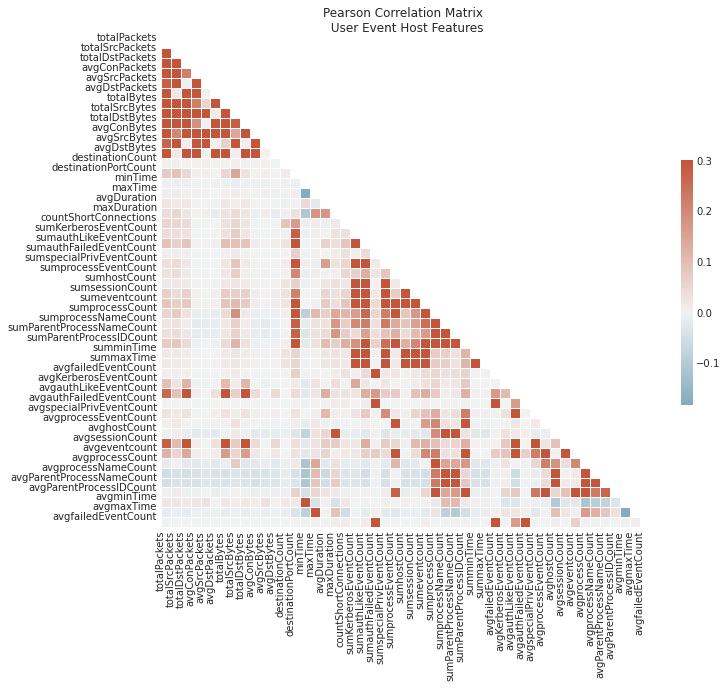

In [74]:
corr = combinedData.corr()

# Generate a mask for the upper triangle
mask = np.triu(np.ones_like(corr, dtype=bool))

# Set up the matplotlib figure
f, ax = plt.subplots(figsize=(11, 9))

# Generate a custom diverging colormap
cmap = sns.diverging_palette(230, 20, as_cmap=True)


# ax = plt.axes()
# Draw the heatmap with the mask and correct aspect ratio
ax = sns.heatmap(
    corr,
    mask=mask,
    cmap=cmap,
    vmax=0.3,
    center=0,
    square=True,
    linewidths=0.5,
    cbar_kws={"shrink": 0.5},
)
ax.set_xticks(corr.reset_index().index)
ax.set_xticklabels(corr.columns)
ax.set_yticks(corr.reset_index().index)
ax.set_yticklabels(corr.columns)


plt.title("Pearson Correlation Matrix \n User Event Host Features");

Above I plotted the correlation matrix of all of the features. Generally in machine learning, we don't want any features to be too strongly correlated as that just tends to insert redundant information into the model. Nothing Over 0.3 here suggests we are safe to move forward.

<a id='ML'></a>
# Unsupervised Outlier Detection Methodology

My outlier detection methodology consists of the following steps:
 - Apply k-means clustering to feature set multiple times tracking the loss function. 
 - Plot this identifying the "elbow point" indicating the optimal number of classes. 
 - Assign each device in a cluster and calculate their distance from the center of the class. 
 - Apply zscore methodology for each classes distances to identify devices that are an outlier from their class. 
 
 
Time permitting, more sophisticated methods would be applied but this method is a good balance between demonstrating value and understandability. We would also look perform more feature engineering and development as well as look into why there are so many more devices in 

In [75]:
combinedData = combinedData.set_index('host')

Confirming that we don't have any null values in the dataset.

In [103]:
combinedData.dropna().shape
combinedData.shape

(8488, 49)

(8488, 49)

## Identifying Optimal Number of Clusters

We will iteratively fit K-Means clustering algorithm varying the number of clusters the algorithm will fit to. For each of those models we will track the performance by looking at the silhouette score. This score calculates the average intra-cluster distance and compares it to the mean nearest-cluster distance.

But first, since we are working with planar distances, we need to preprocess the features to be on the same scale. We are applying a StandardScaler() which essentially calculates the z-score for each feature. 

In [104]:
from sklearn import preprocessing
scaler = preprocessing.StandardScaler().fit(combinedData)
xScaled = scaler.transform(combinedData)

In [169]:
# ended up not needing this but usefull so saving code. 
# scaledData = pd.DataFrame(xScaled, index=combinedData.index, columns=scaler.get_feature_names_out(),)

In [81]:
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score

num_clusters = np.arange(2,20)
results = {}
for size in num_clusters:
    model = KMeans(n_clusters = size, max_iter=100000).fit(xScaled)
    predictions = model.predict(xScaled)
    results[size] = silhouette_score(xScaled, predictions)

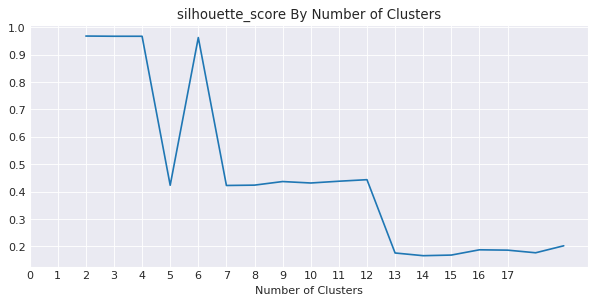

In [184]:
plt.figure(figsize=(9,4), dpi= 80)
ax = sns.lineplot(data=results)
ax.set_xticks(range(len(results)))
ax.set_title('silhouette_score By Number of Clusters')
ax.set_xlabel('Number of Clusters')
plt.show();

The spike after 5 followed by the drop to me is an indicator of overfitting. Based on this I will set our number of clusters to 5. 

## Final Clustering and Outlier Detection

In [157]:
nClusters = 5
model = KMeans(n_clusters=nClusters, max_iter=100000).fit(xScaled)
predictions = model.predict(xScaled)
clusteredData = combinedData
clusteredData['cluster']= predictions
## Get the squared distance to the cluster center

clusteredData['distanceToClusterCenter'] = (model.transform(xScaled)**2).sum(axis=1).round(5)

In [158]:
zscore = lambda x: (x - x.mean()) / x.std()
clusteredData.drop(columns='zScoreDistance', inplace=True)
clusteredData.insert(len(clusteredData.columns), 'zScoreDistance', clusteredData.groupby(['cluster'])['distanceToClusterCenter'].transform(zscore))

In [159]:
clusteredData['RiskScore'] =(clusteredData.zScoreDistance.abs())
clusteredData[['cluster','distanceToClusterCenter','zScoreDistance','RiskScore']].sort_values('RiskScore', ascending=False).head(5)

,cluster,distanceToClusterCenter,zScoreDistance,RiskScore
host,,,,
"(Comp897367, Comp897367)",0,121714.39021,66.368024,66.368024
"(Comp158828, Comp158828)",0,88849.05178,34.130817,34.130817
"(Comp627564, Comp627564)",4,96119.76258,25.960324,25.960324
"(Comp755918, Comp755918)",0,76724.60118,22.238093,22.238093
"(Comp030334, Comp030334)",4,84012.06575,18.444013,18.444013


In [160]:
clusteredData.cluster.value_counts(sort=False)

0    7297
4    1183
1       4
3       1
2       3
Name: cluster, dtype: int64

In [162]:
clusteredData[clusteredData.RiskScore>3].shape


(26, 54)

We now have clustered data with an overall RiskScore field. The higher the value of this field, the more anomalous. Our usual zscore threshold is 3 and above you can see that there are 26 devices that are considered outliers. Those could be further prioritized in descending order by the RiskScore value as the most anomalous would loosely correlate to the most risky. 


Let's take a quick look at the distribution of these values. For visualization purposes I excluded risk scores greater than 10. These would ruin the scale of the visuals. 

<Figure size 640x560 with 0 Axes>

<AxesSubplot:xlabel='cluster', ylabel='zScoreDistance'>

Text(0.5, 1.0, 'Box Plot of Clusters')

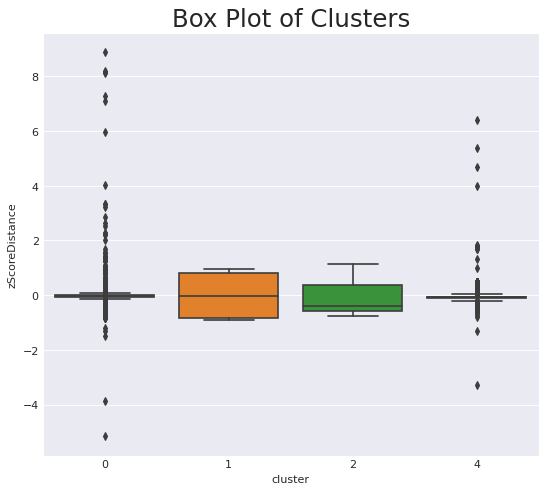

In [166]:
# Draw Plot
plt.figure(figsize=(8,7), dpi= 80)
sns.boxplot(x='cluster', y='zScoreDistance', data=clusteredData[clusteredData.RiskScore<10], )

# Decoration
plt.title('Box Plot of Clusters', fontsize=22)
plt.show()

Finally, let's take a look at a couple of these outliers. I included the overall means for each feature for comparison.
- Comp897367
    - This device has significantly less packets that the average as well as a lower duration. 
    - But at the same time, this device has very high number of process names and parentProcesIDs
- Comp158828
    - The totalDstBytes for this device is low compared to the average.
    - The number of sessions is very high compared to the average as  well as the avgspecialPrivEventCount.

In [179]:
pd.set_option('display.float_format', lambda x: '%.12f' % x)
a = clusteredData[clusteredData.RiskScore>3].sort_values('RiskScore', ascending=False).head(2).T
b=pd.concat([a, clusteredData.describe().loc['mean']], axis=1)
b

,"(Comp897367, Comp897367)","(Comp158828, Comp158828)",mean
totalPackets,17130.000000000000,667012.000000000000,1744320.792766258353
totalSrcPackets,16662.000000000000,665533.000000000000,1013724.728440150851
totalDstPackets,468.000000000000,1479.000000000000,730596.064326107502
avgConPackets,4.007017543860,255.952417498081,248.595576344858
avgSrcPackets,3.897543859649,255.384881043745,174.000509063199
avgDstPackets,0.109473684211,0.567536454336,74.595067281659
totalBytes,3964947.000000000000,464209333.000000000000,1023768242.752945303917
totalSrcBytes,3719529.000000000000,463392639.000000000000,312224877.641376078129
totalDstBytes,245418.000000000000,816694.000000000000,711543365.111569285393
avgConBytes,927.472982456140,178130.979662317724,108500.312782848734


# Summary

Over the course of this document, we have demonstrated an effective base method of extracting, transforming clustering and detecting outliers from the netflow and host event data. By no means would I consider this a final model but for the purposes of demonstrating my skillset and knowledge, I think this does quite well. The final model is a K-means clustering algorithm that places devices into 5 clusters, then compares devices to other devices in their own cluster by calculating the distance to the center of the cluster and detecting outliers of each cluster based on that. Over the process of the ETL and data exploration, we demonstrated the use of efficient and scalable computing technologies but using Apache Spark to process the rather large initial files. 

Additional action items given more time:
 - Extracting feature importances from the model and function that identifiers features that contribute most to a risk score for an individual observation. 
 - Additional feature engineering is always time well spent. Input on potential useful(or useless) features from subject matter experts could improve effectiveness significantly. 
 - More sophisticated clustering and outlier techniques can be experimented with. Perhaps creating a ensemble approach where multiple models score devices from different perspectives. However, close attention should be paid to scope, complexity and understandability. 

 